<a href="https://colab.research.google.com/github/bathicodes/EXPERIMENTS/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# import dependencies
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib for visualization and tqdm for progress
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# check version
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [2]:
# import helper functions from github
import requests
from pathlib import Path

# download helper function
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

helper_functions.py already exist


In [3]:
# import accuracy metric
from helper_functions import accuracy_fn

# DATA

## Getting dataset

In [4]:
# setup training dataset
from torchvision import datasets

train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# check the class names in downloaded dataset
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# check length of train data and test data
len(train_data), len(test_data)

(50000, 10000)

In [7]:
# check first training sample
image, label = train_data[0]
image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [8]:
# get corrosponding indexes
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
# check input and output of the data
print(f"Image shape: {image.shape} -> [color_channels, heights, width]")
print(f"Class names: {class_names[label]}")

Image shape: torch.Size([3, 32, 32]) -> [color_channels, heights, width]
Class names: frog


## Visualize data

Image shape torch.Size([32, 32, 3])


(-0.5, 31.5, 31.5, -0.5)

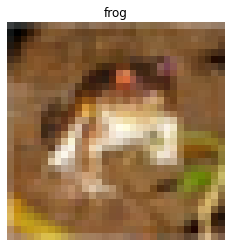

In [10]:
# plot sample as it recivied

image, label = train_data[0]
image = torch.permute(image, (1,2,0)) # use this when plot RGB images
print(f"Image shape {image.shape}")
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

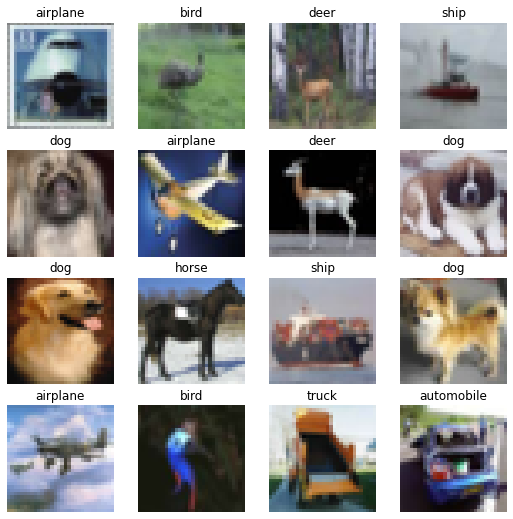

In [11]:
# plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1, cols*rows+1):
  random_idx = torch.randint(1, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  img = torch.permute(img, (1,2,0)) # use this to plot RGB images
  plt.imshow(img)
  plt.title(class_names[label])
  plt.axis(False)

## Prepare DataLoaders

In [12]:
from torch.utils.data import DataLoader

# setup batch size
BATCH_SIZE=32

# turn dataset into python iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f10df9fb130>,
 <torch.utils.data.dataloader.DataLoader at 0x7f118a7be3d0>)

In [13]:
# check data loaders
print(f"Length of train dataloader: {len(train_dataloader)} batches of: {BATCH_SIZE} ")
print(f"Length of test dataloader: {len(test_dataloader)} batches of: {BATCH_SIZE}")

Length of train dataloader: 1563 batches of: 32 
Length of test dataloader: 313 batches of: 32


In [14]:
# check inside of train dataloader
train_featuers_batch, train_label_batch = next(iter(train_dataloader))
train_featuers_batch.shape, train_label_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Image size: torch.Size([32, 32, 3])
Label: 8, Label size: torch.Size([])


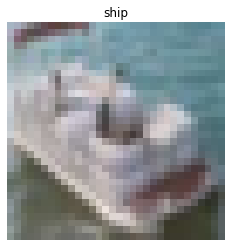

In [15]:
# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_featuers_batch), size=[1]).item()
img, label = train_featuers_batch[random_idx], train_label_batch[random_idx]
img = torch.permute(img, (1,2,0))
plt.imshow(img)
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, Label size: {label.shape}")

# MODEL

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [17]:
class CIFARModelV0(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)

    return x

## Checking the contents of the model

In [18]:
model_0 = CIFARModelV0(input_shape=3,
                       hidden_units=10,
                       output_shape=len(class_names)).to(device)

model_0.parameters

<bound method Module.parameters of CIFARModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)>

In [19]:
# rand_img = torch.randn(size=(3,32,32))
# rand_img.shape

In [20]:
# model_0(rand_img.unsqueeze(0).to(device))

## Train model

In [21]:
# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [22]:
# setup random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setup epochs
epochs = 20

# training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n-------------------")

  ### Training
  train_loss = 0

  # add a loop to go through the data batches
  for batch, (X_train, y_train) in enumerate(train_dataloader):


    # pass data to the target device
    X_train, y_train = X_train.to(device), y_train.to(device)

    # preparing for training
    model_0.train()

    # 1. forward pass
    y_pred = model_0(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)
    train_loss += loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # print status
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X_train)} / {len(train_dataloader.dataset)} sample")

  # devide the total train loss by the length of the train data loader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():

    # add a loop through a testing data batches
    for batch, (X_test, y_test) in enumerate(test_dataloader):

      # pass the data to target device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. forward pass
      test_pred = model_0(X_test)

      # 2. calculate the loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # calculate the average loss for each batch
    test_loss /= len(test_dataloader)

    # calculate the average acc for each batch
    test_acc /= len(test_dataloader)

  # print status
  print(f"\nTrain loss: {train_loss:.4f} | Test_loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 
-------------------
Looked at 0 / 50000 sample
Looked at 12800 / 50000 sample
Looked at 25600 / 50000 sample
Looked at 38400 / 50000 sample

Train loss: 2.0519 | Test_loss: 1.7115 | Test acc: 37.9992
Epoch: 1 
-------------------
Looked at 0 / 50000 sample
Looked at 12800 / 50000 sample
Looked at 25600 / 50000 sample
Looked at 38400 / 50000 sample

Train loss: 1.5280 | Test_loss: 1.4930 | Test acc: 46.8750
Epoch: 2 
-------------------
Looked at 0 / 50000 sample
Looked at 12800 / 50000 sample
Looked at 25600 / 50000 sample
Looked at 38400 / 50000 sample

Train loss: 1.3692 | Test_loss: 1.3905 | Test acc: 51.1881
Epoch: 3 
-------------------
Looked at 0 / 50000 sample
Looked at 12800 / 50000 sample
Looked at 25600 / 50000 sample
Looked at 38400 / 50000 sample

Train loss: 1.3046 | Test_loss: 1.3329 | Test acc: 52.0767
Epoch: 4 
-------------------
Looked at 0 / 50000 sample
Looked at 12800 / 50000 sample
Looked at 25600 / 50000 sample
Looked at 38400 / 50000 sample

Train los